An indepth tutorial to understand different weight initialization techniques.

#### Weight Initialization

Every layer (e.g., nn.Linear, nn.Conv2d) has learnable parameters—weights and biases—which are initialized before training begins. Poor initialization can lead to:
1. Vanishing/exploding gradients.
2. Slow convergence.
3. Getting stuck in poor local minima.

In [32]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<b>1. Zero Initialization (Bad)</b>

In [1]:
# nn.init.constant_(layer.weight, 0)

<b>2. Random Initialization</b>

In [2]:
# nn.init.normal_(layer.weight, mean=0.0, std=0.01)
# nn.init.uniform_(layer.weight, a=-0.1, b=0.1)

<b>3. Xavier (Glorot) Initialization</b>

For tanh / sigmoid activations.

In [3]:
# nn.init.xavier_uniform_(layer.weight)
# nn.init.xavier_normal_(layer.weight)

<b>4. Kaiming (He) Initialization</b>

For ReLU and variants.

In [5]:
# nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
# nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='leaky_relu')

<b>5. Orthogonal Initialization</b>

Good for RNNs or deep nets with stable gradients.

In [7]:
# nn.init.orthogonal_(layer.weight, gain=1.0)

<b>6. Sparse Initialization</b>

Useful in some specific tasks (e.g., NLP).

In [9]:
# nn.init.sparse_(layer.weight, sparsity=0.1)

<b>Example on training a MLP on synthetic data clf</b>

In [17]:
# Data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Total train dataset: {X.shape}")
print(f"Total tesst dataset: {y.shape}")
print(f"X_train split: {X_train.shape}")
print(f"X_test split: {X_test.shape}")
print(f"y_train split: {y_train.shape}")
print(f"y_test split: {y_test.shape}")

Total train dataset: (1000, 2)
Total tesst dataset: (1000,)
X_train split: (800, 2)
X_test split: (200, 2)
y_train split: (800,)
y_test split: (200,)


In [20]:
# Creating tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [26]:
class MLP(nn.Module):
    def __init__(self, init_type="xavier"):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 2)
        self.init_weights(init_type)

    def init_weights(self, method):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if method == "xavier":
                    nn.init.xavier_uniform_(m.weight)
                elif method == "kaiming":
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif method == "constant":
                    nn.init.constant_(m.weight, 0.01)
                elif method == "zero":
                    nn.init.constant_(m.weight, 0)
                else:
                    nn.init.normal_(m.weight, mean=0.0, std=1.0)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [27]:
def train_model(init_type, epochs=50):
    model = MLP(init_type)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()        
        optimizer.step()
        losses.append(loss.item())

    # Evaluate
    model.eval()
    preds = torch.argmax(model(X_test), dim=1)
    acc = (preds == y_test).float().mean().item()
    return losses, acc

Training with xavier init...
Training with kaiming init...
Training with constant init...
Training with zero init...


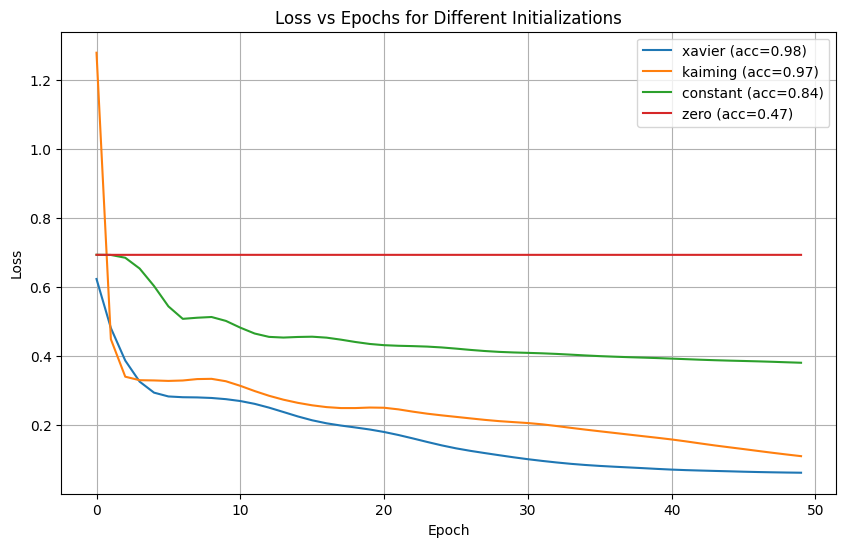

In [29]:
methods = ["xavier", "kaiming", "constant", "zero"] # "random"
results = {}

for method in methods:
    print(f"Training with {method} init...")
    losses, acc = train_model(method)
    results[method] = {"losses": losses, "acc": acc}

# Plot losses
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(results[method]["losses"], label=f"{method} (acc={results[method]['acc']:.2f})")

plt.title("Loss vs Epochs for Different Initializations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

<b>Experimenting on an image dataset classification task</b>

In [33]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR10 (tiny RGB images, 10 classes)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100.0%


In [34]:
class CNNClf(nn.Module):
    def __init__(self, init_type="xavier"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.init_weights(init_type)

    def init_weights(self, init_type):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_type == "xavier":
                    nn.init.xavier_uniform_(m.weight)
                elif init_type == "kaiming":
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif init_type == "zero":
                    nn.init.constant_(m.weight, 0)
                elif init_type == "constant":
                    nn.init.constant_(m.weight, 0.01)
                else:
                    nn.init.normal_(m.weight, mean=0.0, std=1.0)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [35]:
def train_model(init_type, epochs=5):
    model = CNNClf(init_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(trainloader))

        # Eval
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)

        print(f"[{init_type}] Epoch {epoch+1}/{epochs} | Loss: {train_loss[-1]:.3f} | Test Acc: {test_acc[-1]:.2f}%")

    return train_loss, test_acc

In [36]:
init_types = ["xavier", "kaiming", "constant", "zero", "random"]
results = {}

for init in init_types:
    print(f"\nTraining with {init} initialization...")
    loss, acc = train_model(init, epochs=10)
    results[init] = {"loss": loss, "acc": acc}


Training with xavier initialization...
[xavier] Epoch 1/10 | Loss: 1.371 | Test Acc: 61.40%
[xavier] Epoch 2/10 | Loss: 1.000 | Test Acc: 67.12%
[xavier] Epoch 3/10 | Loss: 0.858 | Test Acc: 69.05%
[xavier] Epoch 4/10 | Loss: 0.754 | Test Acc: 70.28%
[xavier] Epoch 5/10 | Loss: 0.672 | Test Acc: 70.72%
[xavier] Epoch 6/10 | Loss: 0.592 | Test Acc: 72.32%
[xavier] Epoch 7/10 | Loss: 0.517 | Test Acc: 72.82%
[xavier] Epoch 8/10 | Loss: 0.448 | Test Acc: 72.38%
[xavier] Epoch 9/10 | Loss: 0.385 | Test Acc: 72.36%
[xavier] Epoch 10/10 | Loss: 0.323 | Test Acc: 72.78%

Training with kaiming initialization...
[kaiming] Epoch 1/10 | Loss: 1.390 | Test Acc: 58.05%
[kaiming] Epoch 2/10 | Loss: 1.008 | Test Acc: 66.14%
[kaiming] Epoch 3/10 | Loss: 0.855 | Test Acc: 68.87%
[kaiming] Epoch 4/10 | Loss: 0.760 | Test Acc: 69.85%
[kaiming] Epoch 5/10 | Loss: 0.679 | Test Acc: 71.06%
[kaiming] Epoch 6/10 | Loss: 0.606 | Test Acc: 71.58%
[kaiming] Epoch 7/10 | Loss: 0.543 | Test Acc: 70.85%
[kaiming] 

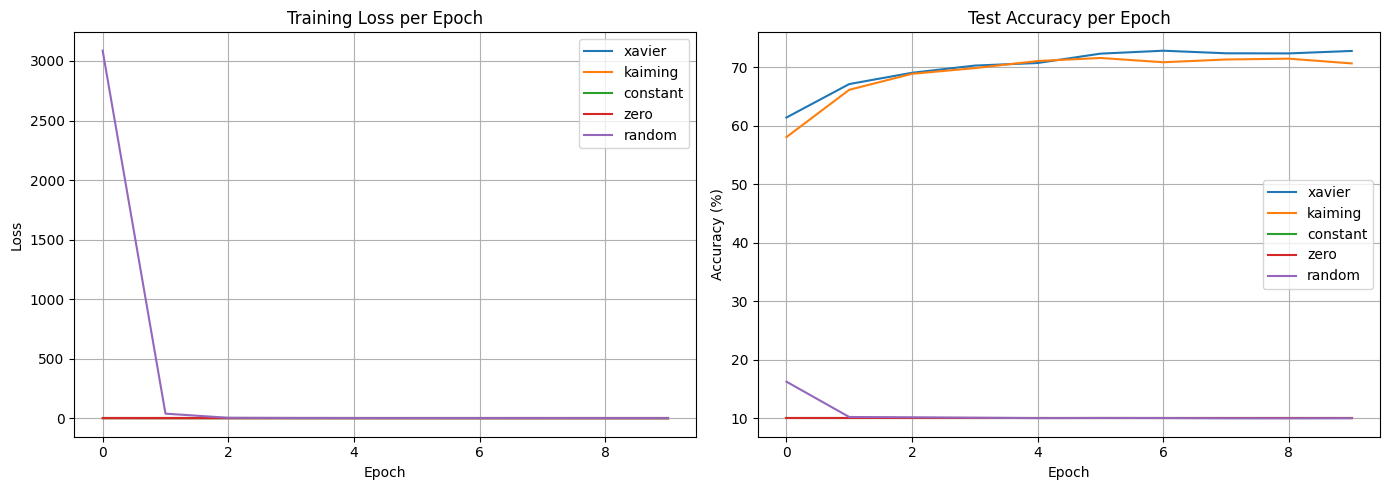

In [37]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for init in init_types:
    plt.plot(results[init]["loss"], label=init)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
for init in init_types:
    plt.plot(results[init]["acc"], label=init)
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Sharing Weights

Allows different parts of a model to reuse the same parameters, which can save memory, enforce symmetry, and encode useful inductive biases.

In [38]:
class SharedWeightNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Create one shared linear layer
        self.shared_fc = nn.Linear(10, 20)

        # Use it in two different places
        self.branch1 = self.shared_fc
        self.branch2 = self.shared_fc  # Sharing weights here

        self.output = nn.Linear(20, 1)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        combined = (out1 + out2) / 2
        return self.output(F.relu(combined))

Both `branch1` and `branch2` use the same weight and bias, and will be updated together during backpropagation.

In [39]:
# Test
model = SharedWeightNet()
x = torch.randn(5, 10)
output = model(x)
print(output)

tensor([[ 0.1342],
        [-0.0386],
        [ 0.1705],
        [ 0.1539],
        [ 0.1351]], grad_fn=<AddmmBackward0>)


This confirms both branches use the same memory address — same tensor.

In [41]:
print(model.branch1.weight.data_ptr() == model.branch2.weight.data_ptr())  # True

True


<b>Use Case: Siamese Network</b>

A Siamese network is a deep learning architecture designed to compare two inputs by processing them through identical neural networks and measuring their similarity. It consists of two or more subnetworks (often called “twins”) that share the same parameters and weights, ensuring both inputs are transformed using the same feature extraction logic. The network outputs embeddings (numeric representations) for each input, and a similarity score is computed between them—for example, using cosine similarity or Euclidean distance. This approach is particularly useful for tasks where the relationship between pairs of data points matters more than individual classifications, such as face verification, signature matching, or detecting duplicate text.

Training a Siamese network typically involves pairs or triplets of data. For example, in face recognition, the network might receive two images: a “positive” pair (same person) and a “negative” pair (different people). The goal is to minimize the distance between embeddings of similar pairs while maximizing it for dissimilar ones. Loss functions like contrastive loss or triplet loss enforce this behavior. Triplet loss, for instance, uses an anchor, a positive example (same class as anchor), and a negative example (different class), adjusting weights so the anchor is closer to the positive than the negative by a defined margin. This setup allows the network to learn meaningful features without requiring labeled class data for every possible input, making it efficient for scenarios with limited labeled data.

Source: https://milvus.io/ai-quick-reference/what-is-a-siamese-network-in-deep-learning

In [42]:
class Siamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.out = nn.Linear(32, 1)

    def forward(self, x1, x2):
        e1 = self.shared_encoder(x1)
        e2 = self.shared_encoder(x2)
        distance = torch.abs(e1 - e2)
        return torch.sigmoid(self.out(distance))

<b>Use Case: Weight Tying in Autoencoders</b>

Tie decoder weights to the encoder. This ensures that the decoder always uses the transpose of the encoder weights (as in traditional tied autoencoders).

In [43]:
class TiedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(784, 256)
        self.decoder = nn.Linear(256, 784)

        # Tie weights (transpose)
        self.decoder.weight = nn.Parameter(self.encoder.weight.t())

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x

Note that shared weights are different from copied weights.

In [44]:
# This shares weights
layer = nn.Linear(10, 10)
a = layer
b = layer

# This doesn't share weights
a = nn.Linear(10, 10)
b = nn.Linear(10, 10)  # new weights